In [1]:
import numpy as np
import pandas as pd
import networkx as nx


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

Variables that I care about right now: 
- `PY` : Publish Year
- `methods` 
    1. Weather/Weather Remote Sensing 
    2. Big data/Machine learning 
    3. Mapping & GIS
    4. Mechanistic modelling   
    5. Community guidance & tools 
    6. Interviews/surveys 
    7. Social media or crowd sourcing
    8. newspaper/archival/photos 
    9. conceptual framework
    10. Lit_review/critical/opinionpiece
    11. Economic, regression, or Psych Experiment
    12. Physical Experiment
    13. Trend/time-series analysis
    14. database 
    15. other 
    16. Event Case Study
    17. Land Remote Sensing
- `meta_topic`
    1. Climate Change
    2. Long Term Impact
    3. Land Use
    4. Policy
    5. Gender
    6. Management
    7. Transportation
    
    "Climate change" = 1, "Long term impact" = 2,   "Land use" = 3, "Policy" = 4,"Gender"=5, "Management" = 6, "Transportation" = 7

Import and clean data by dropping unnedeed columns, renaming others for easier use, and turn `methods` into categorical data

In [2]:
data = pd.read_csv('./ScreenedData_for-visulization.csv')

# Drop columns we don't need
data.drop(['Key', 'DT2', 'TC', 'PA', 'CR', 'C1', 'SR', 'BE', 'FU', 'BN', 'SN', 'PN', 'PP', 
           'PU', 'VL', 'UT', 'NR', 'SC', 'U2', 'WC', 'EM', 'SE', 'GA', 'BO', 'RP', 'DB', 
           'AU_UN_NR', 'AU_UN', 'SR_FULL','About an actual event',  'Screen3_Planning' ], axis=1, inplace=True)

# These are columns that might be useful in future analyses, but I don't need right now
data.drop(['DT', 'LA', 'SO', 'DE', 'ID', 'DI', 'AU1_UN'], axis = 1, inplace = True)

#data['PY'] = data['PY'].astype('datetime64[ns]').dt.year

data.rename(columns = {'Study method':'methods', 
                       'After a flood': 'impacts', 
                       'Paper framing': 'framing', 
                       'Meta topic': 'meta_topic',
                       'Before a flood': 'before',
                       'During a flood': 'during',
                       'Urban/Rural': 'urban_rural',
                       'Flood type': 'flood_type'
                      }, inplace = True)

#data['methods'] = data['methods'].astype('category')
#data['impacts'] = data['impacts'].astype('category')

#data['methods'] = data['methods'].str.split("_", expand = False)
#data['framing'] = data['framing'].astype('category')
#data['meta_topic'] = data['meta_topic'].str.split("_", expand = False)

In [3]:
data.head()

,AU,TI,AB,PY,meta_topic,framing,before,during,impacts,methods,urban_rural,flood_type
0,Rajesh S;Jain S;Sharma P,Inherent vulnerability assessment of rural hou...,The recent trend of shifting focus from hazard...,2018.0,0,2,0,0,2,6_9_11,0,1
1,Bergholt D;Lujala P,"Climate-related natural disasters, economic gr...",Global warming is expected to make the climate...,2012.0,1,0,0,0,2_7,11_13,0,1
2,Nyaupane Gp;Chhetri N,Vulnerability to climate change of nature-base...,"Given their unique natural attractions, includ...",2009.0,1,0,0,0,2_7,9,2,5_8
3,Mcclelland Dm;Bowles Ds,Estimating life loss for dam safety and risk a...,An understanding of life-loss dynamics associa...,2000.0,6,1,0,0,1,9,0,3
4,Soon Nk;Isah N;Ali Mb;Ahmad Ar,Effects of smart tunnel maintenance works on f...,Smart was the light in the tunnel to end devas...,2017.0,6,0,0,0,0,6_8_11,0,1


In [4]:
#str_meta_topic = data['meta_topic'].apply((lambda x: '_'.join(str(e) for e in x)))
data['meta_topic'].unique()

array(['0', '1', '6', '7', '4', '5', '3_6', '1_6', '3', '6_7', '1_3_6',
       '4_6', '1_3', '5_7', '1_5', '1_4', '4_5_6_7', '2_3', '1_2_3_6',
       '1_4_6', '2', '5_6', '3_4_6', '2_4', '2_5', '1_3_4'], dtype=object)

In [12]:
def remove_dupes(list_with_dupes):
      res = []
      [res.append(x) for x in list_with_dupes if x not in res]
      return res

def network_plot_process(data):
    str_list = data.to_list()
    dict_dup_topics = {i:str_list.count(i) for i in str_list}
    topic_freq = pd.DataFrame(list(dict_dup_topics.items()), columns = ['label', 'frequency'])
    
    # make list of edges

    # dictionary comprehension:
    print('beginning dictionary comprehension')
    d_topic = { topic_freq['label'][i] : topic_freq['label'][i].split("_")
        for i in range(len(topic_freq['label']))
      }

    print('creating edgelist')
    edgelist = []
    for k,v in d_topic.items():
          for val in v:
            d = dict(filter(lambda x: val in x[1], d_topic.items()))
            for i in d:
                  edgelist.append((k, i))
            edgelist = remove_dupes(edgelist)
    edgelist = [x for x in edgelist if x[0] != x[1]]
    
    print('creating label topics')
    # drop papers without any meta-topics (bc they mess with the scaling)
    # drop 0 from everything
    topic_labels = topic_freq['label'].to_list()
    #topic_labels.remove('0')

    print('counting frequencies')
    topic_frequencies = topic_freq['frequency'].to_list()
    #topic_frequencies.remove(260)

    print('figuring out node colors')
    # make a color map list based on length
    # node_colors = [len(x) for x in topic_labels]
    node_colors = ["darkgrey" if "_" in x else "orange" for x in topic_labels]
    
    #return topic_labels, topic_frequencies, node_colors, edgelist
    print('plotting now')
    network_plot(topic_labels, topic_frequencies, node_colors, edgelist)

def network_plot(topic_labels, topic_frequencies, node_colors, edgelist):
    B = nx.Graph()

    B.add_nodes_from(topic_labels)
    B.add_edges_from(edgelist)

    M = B.number_of_edges()
    edge_colors = range(2, M + 2)

    nx.draw(B, nodelist = topic_labels, 
            node_size = [x*100 for x in topic_frequencies],
            edge_color = 'grey',
            with_labels = True,
            arrowstyle="->",
            node_color=node_colors, alpha = 0.7
           )

beginning dictionary comprehension
creating edgelist
creating label topics
counting frequencies
figuring out node colors
plotting now


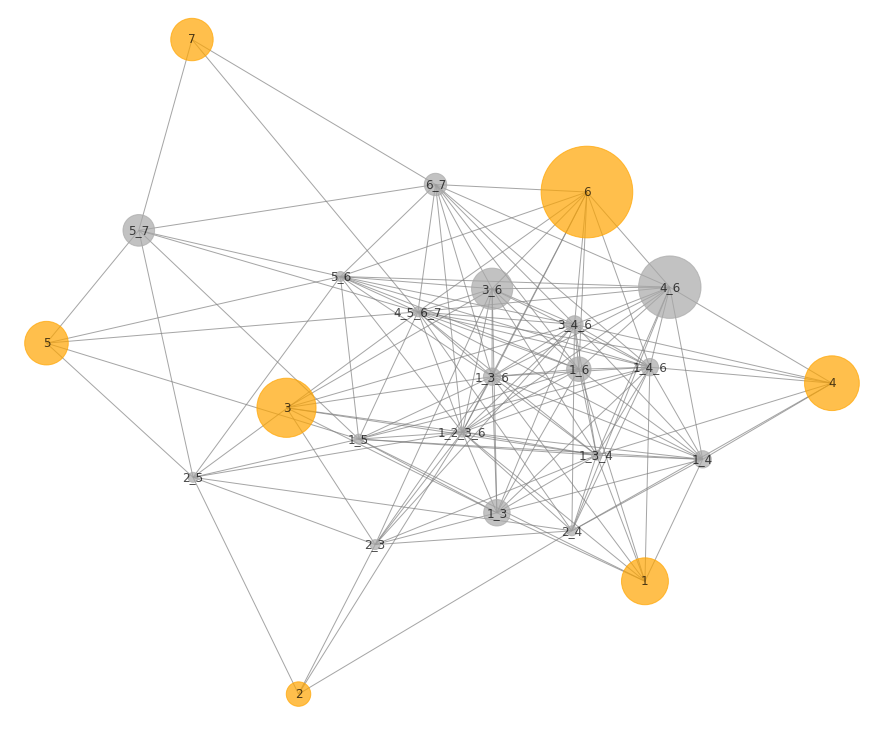

In [8]:
network_plot_process(data['meta_topic'])


beginning dictionary comprehension
creating edgelist
creating label topics
counting frequencies
figuring out node colors
plotting now


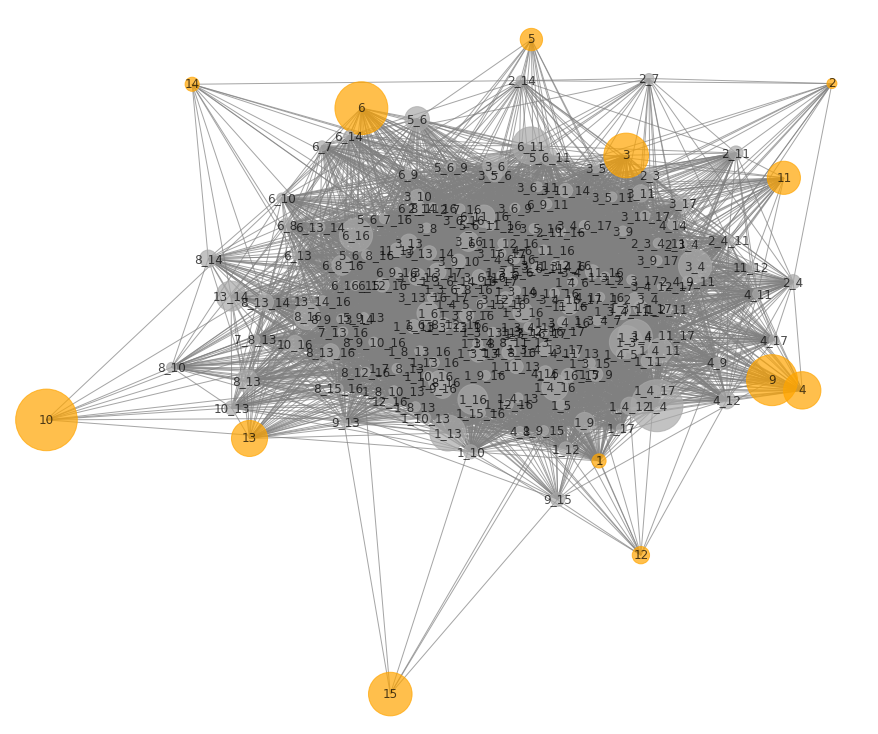

In [13]:
network_plot_process(data['methods'])

In [ ]:
node_colors

In [ ]:
str_meta_list = data['meta_topic'].to_list()

dict_dup_topics = {i:str_meta_list.count(i) for i in str_meta_list}

meta_topic_freq = pd.DataFrame(list(dict_dup_topics.items()), columns=['label','frequency'])
meta_topic_freq

In [ ]:
# make list of edges

# dictionary comprehension:
# d_meta_topic = { str(meta_topic numbers) : list of str(meta_topic) 
#                for i in (number of combinations)}
d_meta_topic = { meta_topic_freq['label'][i] : meta_topic_freq['label'][i].split("_")
    for i in range(len(meta_topic_freq['label']))
  }
# d_meta_topic

def remove_dupes(list_with_dupes):
      res = []
      [res.append(x) for x in list_with_dupes if x not in res]
      return res

edgelist = []

for k,v in d_meta_topic.items():
      for val in v:
        d = dict(filter(lambda x: val in x[1], d_meta_topic.items()))
        for i in d:
              edgelist.append((k, i))
        edgelist = remove_dupes(edgelist)
#print(edgelist)
edgelist = [x for x in edgelist if x[0] != x[1]]
print(edgelist)

In [ ]:
# drop papers without any meta-topics (bc they mess with the scaling)
# drop 0 from everything
topic_labels = meta_topic_freq['label'].to_list()
topic_labels.remove('0')

topic_frequencies = meta_topic_freq['frequency'].to_list()
topic_frequencies.remove(260)

# make a color map list based on length
# node_colors = [len(x) for x in topic_labels]
node_colors = ["blue" if "_" in x else "green" for x in topic_labels]


In [ ]:
topic_labels

In [ ]:
node_colors

In [ ]:
# make the graph
B = nx.Graph()

B.add_nodes_from(topic_labels)
B.add_edges_from(edgelist)

M = B.number_of_edges()
edge_colors = range(2, M + 2)

nx.draw(B, nodelist = topic_labels, 
        node_size = [x*100 for x in topic_frequencies],
        edge_color = 'grey',
        with_labels = True,
        arrowstyle="->",
        node_color=node_colors, alpha = 0.7
       )

TO DO 

make a list of the just the strings that are in your methods column
do one of these to it: https://www.codesansar.com/python-programming-examples/how-count-duplicate-elements-python-list.htm
iterate through the dictionary, putting the key in one list and the value in another
those are the two lists to put in a panda df according to the code in the first example

In [ ]:
# libraries
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd

# Create a data frame with fake data
df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

# plot it
squarify.plot(sizes=df['nb_people'], label=df['group'], alpha=.8 )
plt.axis('off')
plt.show()

In [ ]:
data = pd.read_csv('./ScreenedData_for-visulization.csv')

# Drop columns we don't 
data.drop(['Key', 'DT2', 'TC', 'PA', 'CR', 'C1', 'SR', 'BE', 'FU', 'BN', 'SN', 'PN', 'PP', 
           'PU', 'VL', 'UT', 'NR', 'SC', 'U2', 'WC', 'EM', 'SE', 'GA', 'BO', 'RP', 'DB', 
           'AU_UN_NR', 'AU_UN', 'SR_FULL','About an actual event',  'Screen3_Planning' ], axis=1, inplace=True)

# These are columns that might be useful in future analyses, but I don't need right now
data.drop(['DT', 'LA', 'SO', 'DE', 'ID', 'DI', 'AU1_UN'], axis = 1, inplace = True)

#data['PY'] = data['PY'].astype('datetime64[ns]').dt.year

data.rename(columns = {'Study method':'methods', 
                       'After a flood': 'impacts', 
                       'Paper framing': 'framing', 
                       'Meta topic': 'meta_topic',
                       'Before a flood': 'before',
                       'During a flood': 'during',
                       'Urban/Rural': 'urban_rural',
                       'Flood type': 'flood_type'
                      }, inplace = True)

#data['methods'] = data['methods'].astype('category')
#data['impacts'] = data['impacts'].astype('category')

data['methods'] = data['methods'].str.split("_", expand = False)
#data['framing'] = data['framing'].astype('category')
data['meta_topic'] = data['meta_topic'].str.split("_", expand = False)

In [ ]:
str_methods = data['methods'].apply((lambda x: '_'.join(str(e) for e in x)))

In [ ]:
# str_methods_list: a list where each entry corresponds to one paper
str_methods_list = str_methods.to_list()

# dict_dupes: key is str representing methods, value is frequency
dict_dupes = {i:str_methods_list.count(i) for i in str_methods_list}

methods_freq_df = pd.DataFrame(list(dict_dupes.items()), columns=['label','frequency'])
methods_freq_df

In [ ]:
squarify.plot(sizes=methods_freq_df['frequency'],label=methods_freq_df['label'], alpha=.8)

In [ ]:
# remove combinations of methods that only occur once
methods_nunique_df = methods_freq_df.where(lambda x : x!=1).dropna()
squarify.plot(sizes=methods_nunique_df['frequency'],label=methods_nunique_df['label'], alpha=.8)

In [ ]:
# remove combinations of methods that are only one methods
methods_multiple_df = methods_freq_df[methods_freq_df['label'].str.contains('_')==True]
squarify.plot(sizes=methods_multiple_df['frequency'],label=methods_multiple_df['label'], alpha=.8)

In [ ]:
data['methods'] = data['methods'].str.split("_", expand = False)
data['framing'] = data['framing'].astype('category')
data['meta_topic'] = data['meta_topic'].str.split("_", expand = False)

Looking at total counts for the metatopics

In [ ]:
topics = ["0", "1", "2", "3", "4", "5", "6", "7"]

for topic in topics:
    print(topic , ": " , data.meta_topic.map(lambda d: topic in d).sum())


Finding the overlaps. I know this is the least efficient way in the universe:

In [ ]:
data.where(data.meta_topic.str.len() > 1).meta_topic.describe()

In [ ]:
meta_overlaps = data.where(data.meta_topic.str.len() > 1).meta_topic.dropna()


In [ ]:
meta_overlaps.where(meta_overlaps.str.len() > 2).dropna()

In [ ]:
meta_overlaps.describe()
#[data['meta_topic'].unique() for meta_topic in data.columns]

In [ ]:
data.PY.value_counts().sort_index().plot(x = 'PY', label = 'Total Papers')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Count')

plt.tight_layout()

### References / Tabs I had opened

- [Cleaning a messy dataset using Python](https://medium.com/well-red/cleaning-a-messy-dataset-using-python-7d7ab0bf199b) 
- [Plot each year of a time series on the same x-axis using Pandas](http://atedstone.github.io/pandas-plot-seasons-time-series/)

### Plotting tools to look into

- [Making network graphs interactive with Python and Pyvis](https://towardsdatascience.com/making-network-graphs-interactive-with-python-and-pyvis-b754c22c270)
- [Interactive network visualizations](https://pyvis.readthedocs.io/en/latest/index.html#)
- [Python Graph Gallery](https://www.python-graph-gallery.com/)

